# Gaussian Processes

The main source for this is a blog post written by Katherine Bailey, [Gaussian Processes for Dummies](http://katbailey.github.io/post/gaussian-processes-for-dummies/).
Additional information was gleaned from the slide deck [Introduction to Gaussian Processes](https://www.cs.toronto.edu/~hinton/csc2515/notes/gp_slides_fall08.pdf) by Iain Murray.

__Gaussian Processes__ (GPs) provide an alternative approach to regression problems.
Recall that with Linear Regression we have a response variable $y$ that we assume can be modeled as a function of some predictor $x$, meaning $y = f(x) + \varepsilon$ where $\varepsilon$ is the irreducible error.
Furthermore, we assume that the functional form of $f$ is linear, so we try to estimate the parameters $\beta_0$ and $\beta_1$ which define the intercept and slope of the function, $y = \beta_0 + \beta_1 x + \varepsilon$.

The __Gaussian Process__ approach, however, is _non-parametric_.
Instead of finding estimates of $\beta_0$ and $\beta_1$, it estimates a distribution over all possible _functions_ $f(x)$ that are consistent with the observed data.
As with all Bayesian methods we start with a prior distribution over the function space $f$, and produces a posterior distribution over $f$.

For a formal definition, in the textbook [Machine Learning: A Probabilistic Perspective](https://www.cs.ubc.ca/~murphyk/MLbook/), author Kevin Murphy describes a __Gaussian Process__ as:

> A __Gaussian Process__ defines a prior over functions, whcich can be converted into a posterior over functions once we have seen some data.
> Although it might seem difficult to represent a distribution over a function, it turns out that we only need to be able to define a distribution ober the fucntion's values at a finite, but arbitrary, set of points, say $x_1, \ldots, x_N$.
> A __Gaussian Process__ assumes that $p(f(x_1), \ldots, f(x_N))$ is jointly Gaussian, with some mean $\mu(x)$ and covariance $\Sigma(x)$ given by $\Sigma_{i,j} = k(x_i, x_j)$, where $k$ is a positive definite kernel function.
> The key idea is that if $x_{i}$ and $x_{j}$ are deemed by the kernel to be similar, then we expect the output of the function at those points to be similar, too.

## Multivariate Gaussian Distribution

![Source: Wikipedia](https://upload.wikimedia.org/wikipedia/commons/5/57/Multivariate_Gaussian.png)

The __Multivariate Gaussian Distribution__ forms the backbone of __Gaussian Processes__.
In the image above, we can see a __Bivariate Gaussian Distribution__, a Multivariate Gaussian Distribution over two variables.
In this, $X$ and $Y$ are two independent normally distributed variables, meaning that their covariance is $0$.
If we assume unit-variance for $X$ and $Y$, the covariance matrix is $\Sigma = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix}$.
The joint probability of variables $x_1$ and $x_2$ is given as follows:

$$
{x_{1} \choose x_{2}} \sim \mathcal{N}\Big({\mu_1 \choose \mu_2}, \begin{pmatrix} \sigma_{1,1} & \sigma_{1, 2} \\ \sigma_{2, 1} & \sigma_{2, 2} \end{pmatrix} \Big )
$$

From this, we can derive the _conditional probability_ of one of the variables, $x_i$ _given_ the other $x_j$.
The is how, in a __Gaussian Process__ we can derive the posterior from the prior and our observations.
It's not the case that we're looking at two variables though, but the joint probability of the values of $f(x)$ for all values of $x$ over a finite range, e.g. $x \in [-5, 5]$.

The posterior is the joint probability of our outcome values, some of which have been observed in the data (denoted by $f$) and some which have not (denoted by $f^*$).

$$
{f \choose f_{*}} \sim \mathcal{N}\Big({\mu \choose \mu_{*}}, \begin{pmatrix} K & K_{*} \\ K^{T}_{*} & K_{**} \end{pmatrix} \Big )
$$

Here, $K$ is the matrix output from applying the kernel function to the observed values $x$, giving us the similarity of each observed value $x_i$ to all other observed values $x_j$.
$K_{*}$ is the similarity of training values to the test values.
$K_{**}$ give the similarity of the test values to each other.

To reiterate the underlying process.
There are some points $x$ that we have observed the output of $f(x)$ (denoted as $f$).
There are other points $x_{*}$ for this we would like to estimate $f(x_{*})$ (denoted as $f_{*}$).
What we are trying to estime is the distribution $p(f_{*}|x_{*}, x, f)$, and we assume that $f$ and $f_{*}$ together are jointly Gaussian.
From this we are able to go from the joint distribution $p(f, f_{*})$ to the conditional distribution $p(f_{*}|f)$ (this derivation can be found in Kevin Murphy's book).
What we end up with are the mean function $\mu_{*}$ and the covariance matrix $\Sigma_{*}$ that parameterize our distribution:

$$
f_{*} \sim \mathcal{N}(\mu_{*}, \Sigma_{*})
$$

As there are computational efficiencies gained from working with the standard normal distribution $x \sim \mathcal{N}(0, 1)$, it is essential to express our multivariate normal distribution in terms of standard normals: $f_{*} \sim \mu + B \mathcal{N}(0, I)$, where $B$ is the matrix such that $B B^{T} = \Sigma_{*}$, i.e. $B$ is the square root of our covariance matrix $\Sigma$.
This can be found efficiently using _Cholesky Decomposition_.

From Katherine Bailey:
> Recall that when you have a univariate Gaussian distribution $x \sim \mathcal{N}(\mu, \sigma^2)$ you can express this in relation to the _standard normal distribution_, i.e. as $x \sim \mu + \sigma(\mathcal{N}(0, 1))$

## Coded Example

This example borrows heavily from Nando de Freitas' [UBC Machine Learning Lectures](https://www.cs.ubc.ca/~nando/540-2013/lectures.html).

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# test data
n = 50
x_test = np.linspace(-5, 5, n).reshape(-1, 1)

# defining the kernel function
def kernel(a, b, param):
    sq_dist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2*np.dot(a, b.T)
    return np.exp(-0.5 * (1 / param) * sq_dist)

param = 0.1  # smoothing factor for the kernel. Larger values -> more smoothing
K_ss = kernel(x_test, x_test, param)  # K_{**}

# Cholesky decomposition of the covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))  # adding a small value prevents underflow

# sample 3 sets of std. normals for the test points
f_prior = np.dot(L, np.random.normal(size=(n, 3)))

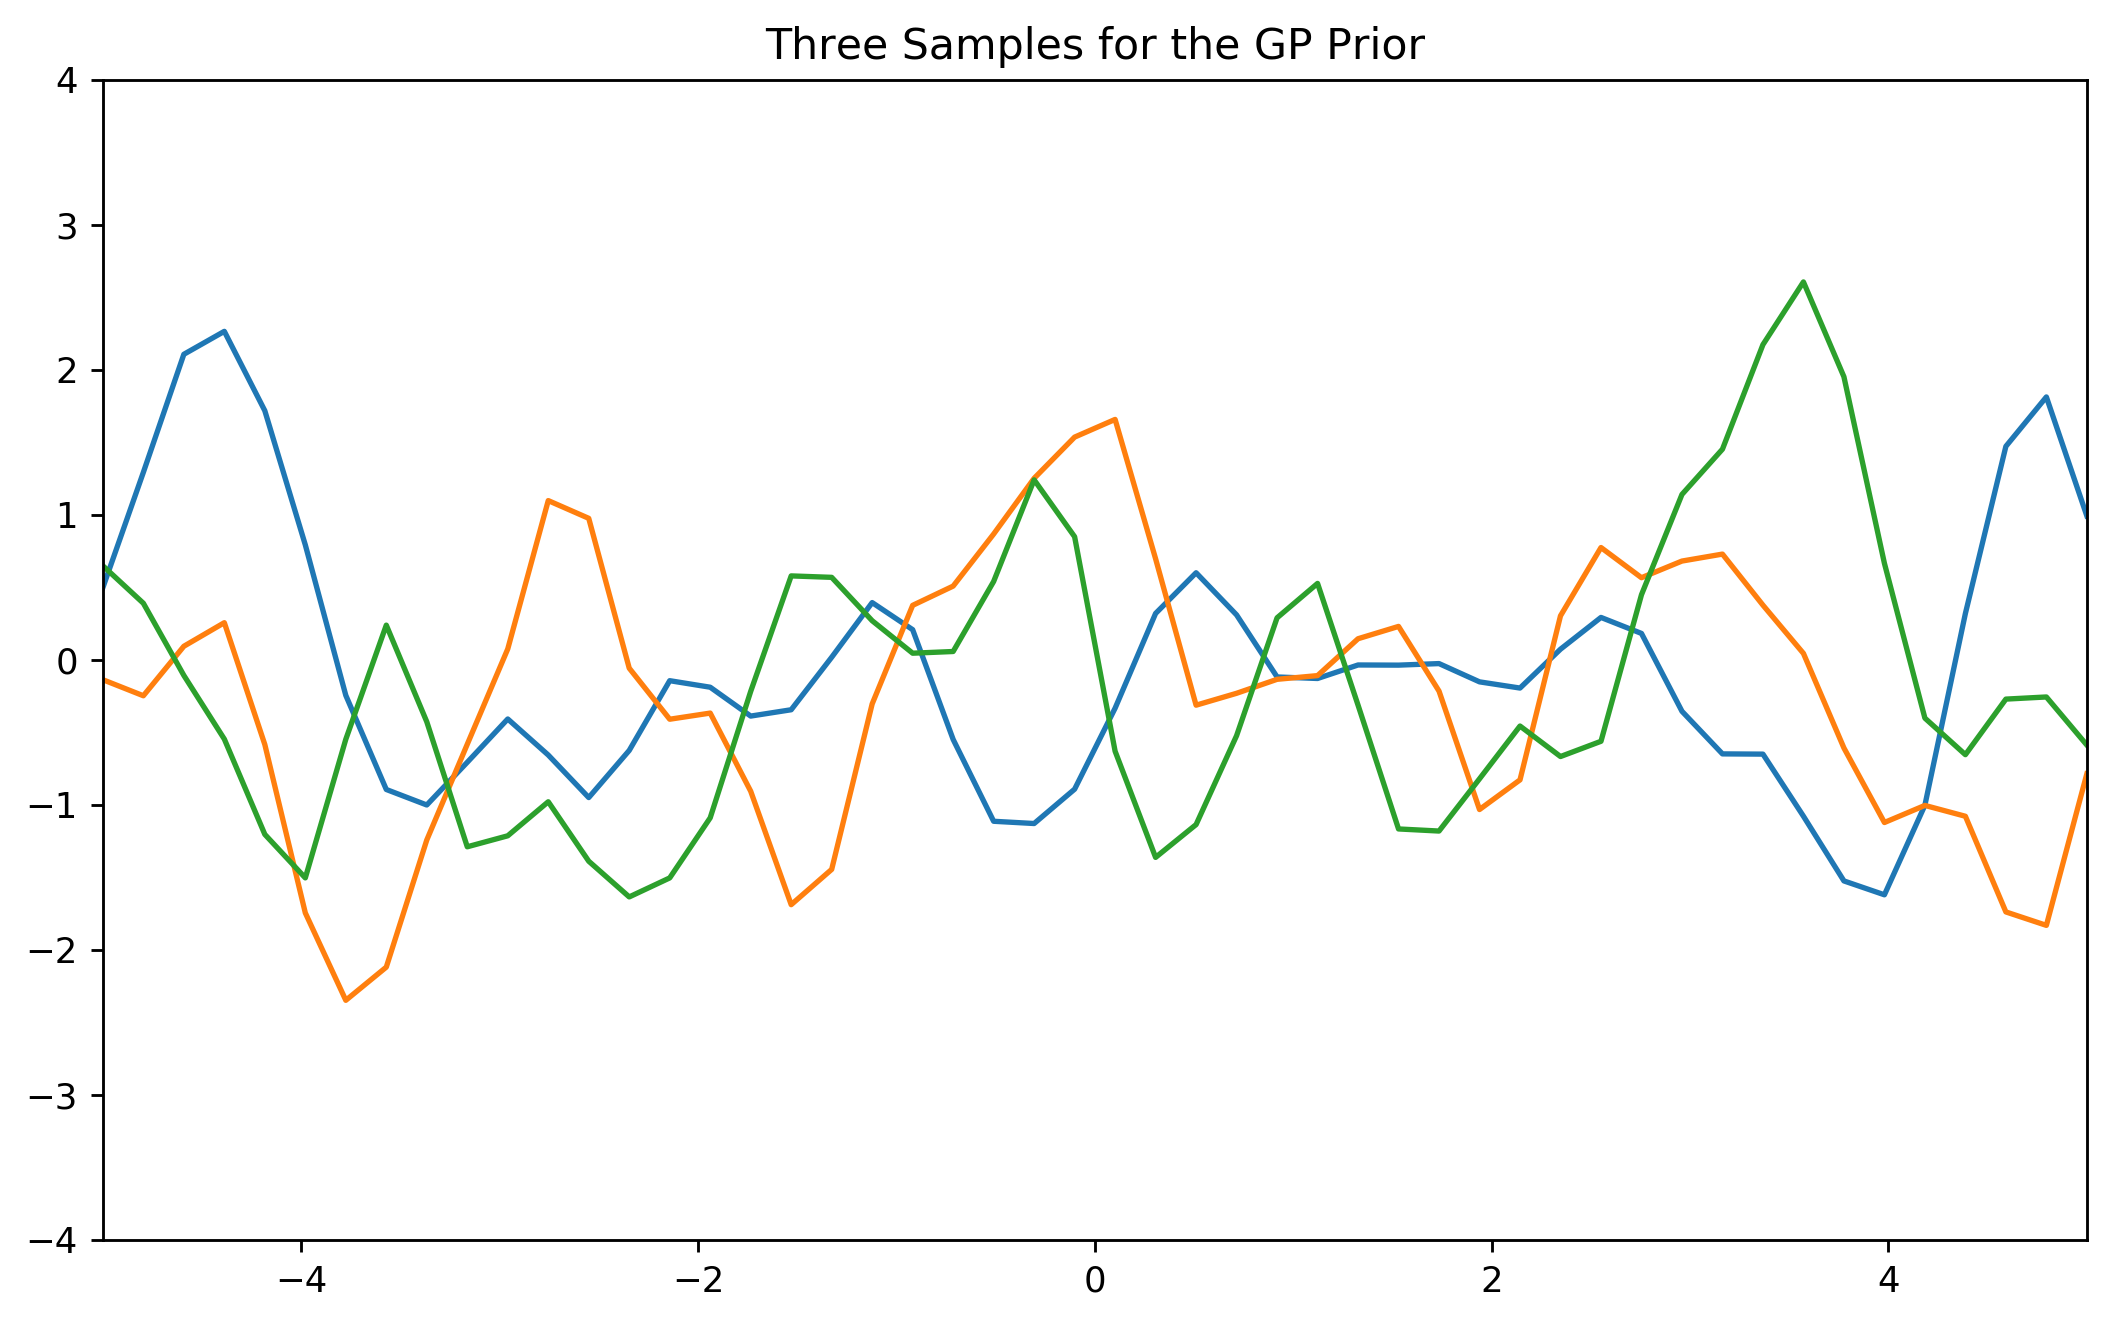

In [4]:
plt.figure(figsize=(10, 6), dpi=256)
plt.plot(x_test, f_prior)
plt.axis([-5, 5, -4, 4])
plt.title('Three Samples for the GP Prior')
plt.show()

To produce our data, we will generate values of $y$ using the $\sin$ function.

In [5]:
# noiseless training data
x_train = np.array([-4, -3, -2, -1, 1, 4]).reshape(-1, 1)
y_train = np.sin(x_train)

Now we apply the kernel function to our training points.

In [6]:
K = kernel(x_train, x_train, param)
L = np.linalg.cholesky(K + 1e-15*np.eye(len(x_train)))

Compute the mean $\mu_{*}$ at our test points $f(x_{*})$.

In [7]:
K_s = kernel(x_train, x_test, param)  # K_{*}
Lk = np.linalg.solve(L, K_s)

mu = np.dot(Lk.T, np.linalg.solve(L, y_train)).reshape((n,))

Compute the standard deviation for plotting purposes.

In [8]:
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
std = np.sqrt(s2)

Draw samples from the posterior at our test points.

In [9]:
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1, 1) + np.dot(L, np.random.normal(size=(n,3)))  # posterior distribution

Plot the results.

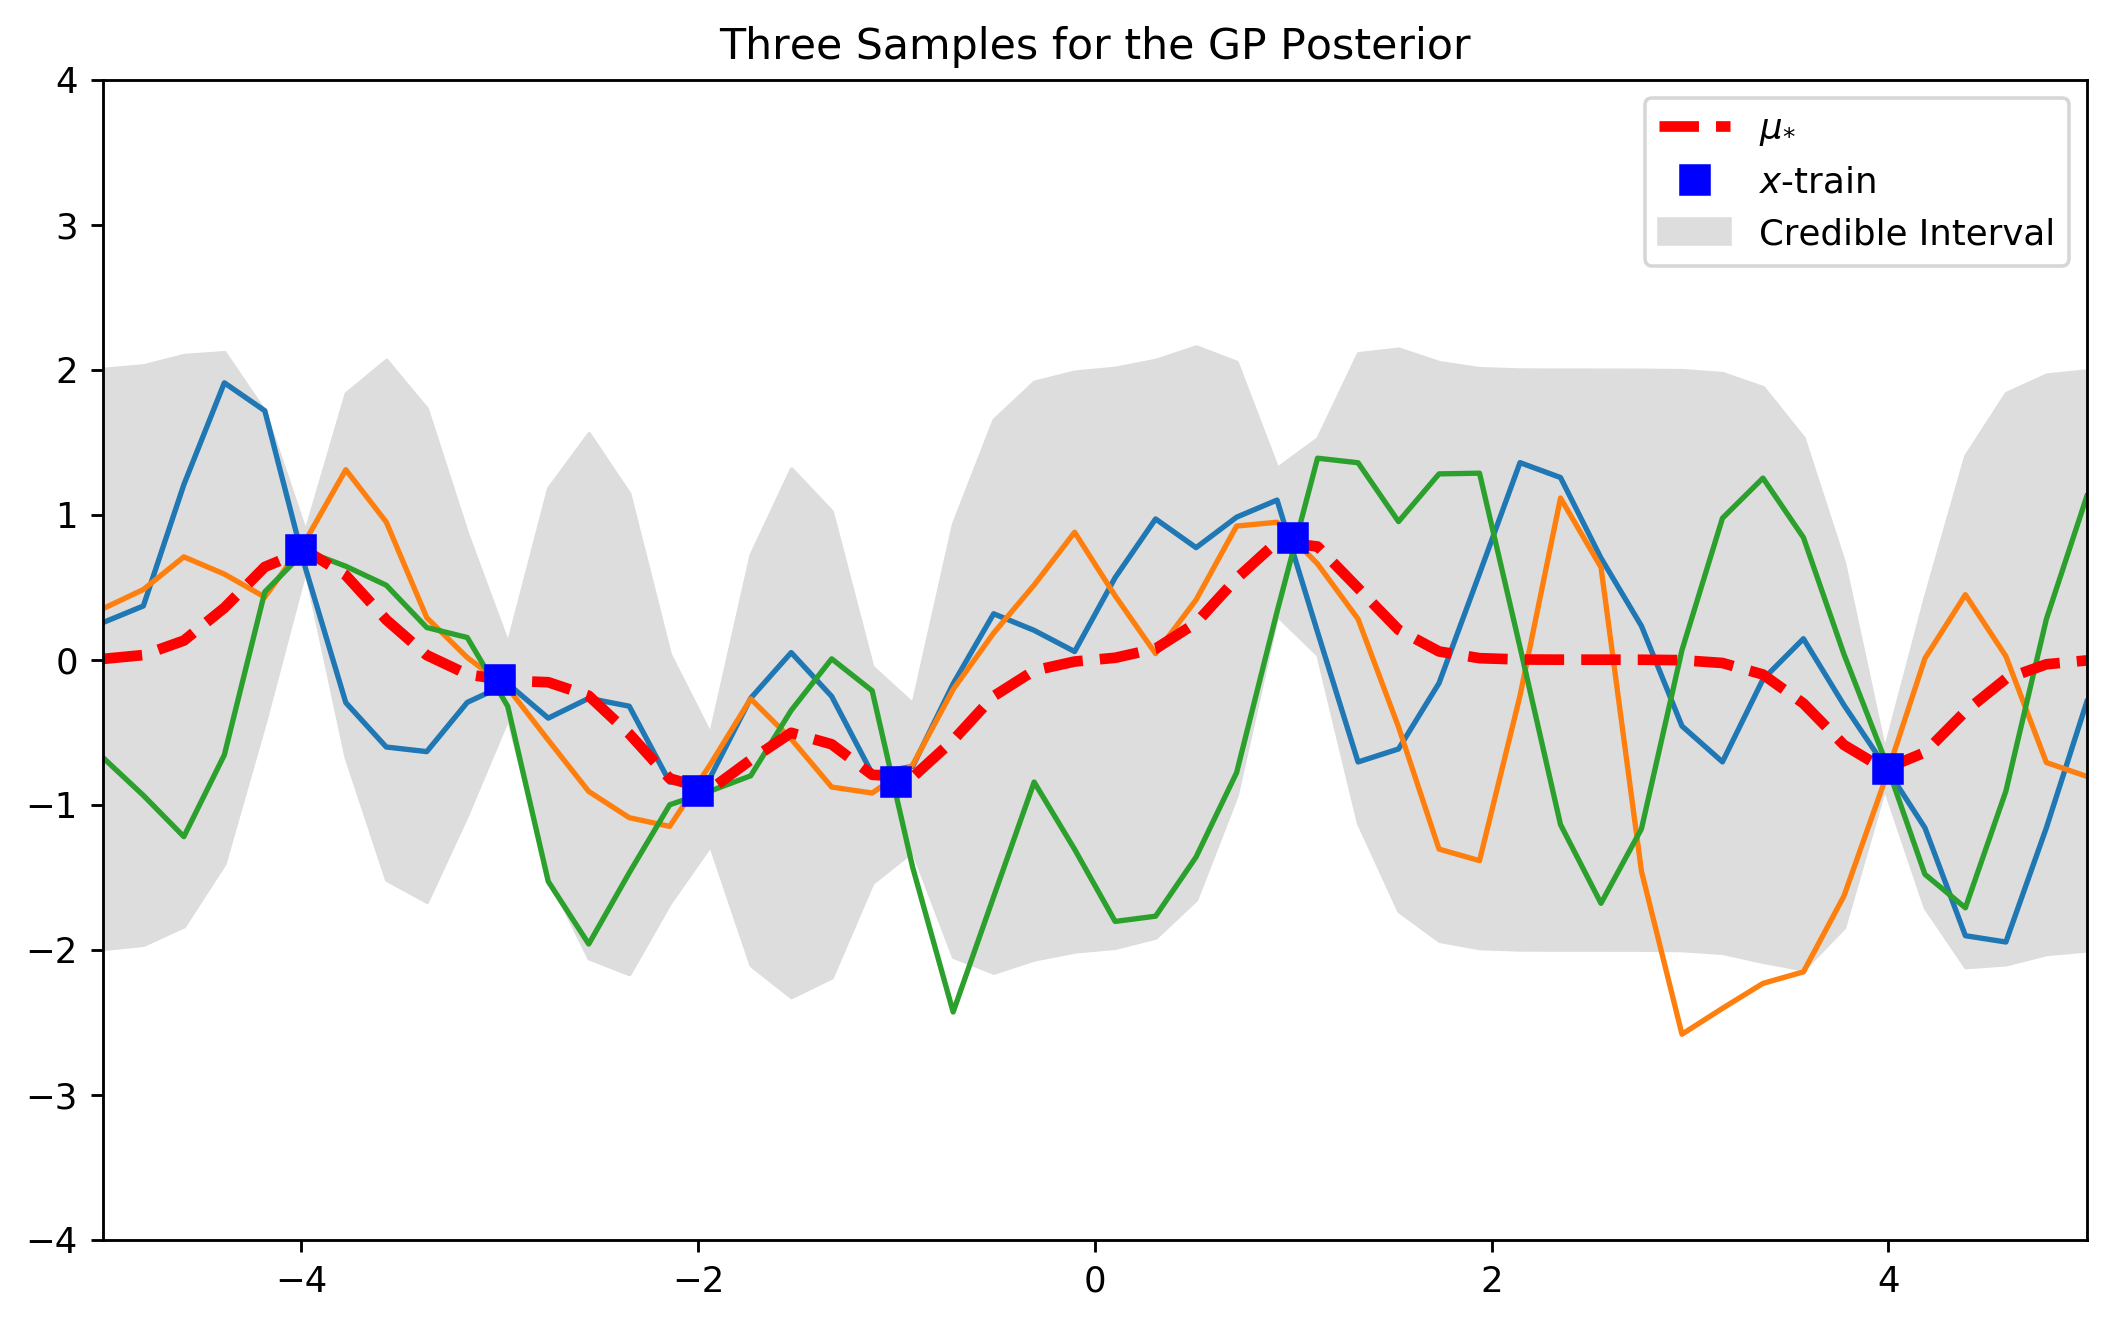

In [10]:
plt.figure(figsize=(10, 6), dpi=256)
plt.plot(x_test, f_post)
plt.gca().fill_between(x_test.flat, mu-2*std, mu+2*std, color='#dddddd', label='Credible Interval')
plt.plot(x_test, mu, 'r--', lw=3, label="$\mu_{*}$")
plt.plot(x_train, y_train, 'bs', ms=8, label='$x$-train')
plt.axis([-5, 5, -4, 4])
plt.title('Three Samples for the GP Posterior')
plt.legend()
plt.show()

Looking at the training points $x$, we can see that they have effectively "reined in" the set of possible functions, the ones being sampled from the posterior all pass through these points.
The dotted red line, representing $\mu_{*}$, is the mean output, and the grey area shows a confidence interval of two standard deviations from the mean, $\mu_{*} \pm 2\sigma$.
Note that the confidence interval is always centered at the mean, as the data used did not have any noise.
Also, notice that at points $x > 1$ the confidence interval stays quite wide.
This is because no observations have been made in this range -- once observations are made here, they too will constrain the observations. 